In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import joblib
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'SBS_Processed_Datasets/04_preprocessed_output.csv')

In [3]:
# Define column groups
user_input_columns = [
    'owner_no', 'model_year', 'kms_driven', 'engine_cc', 
    'mileage_kmpl', 'city_chennai', 'city_delhi', 'city_hyderabad', 
    'city_jaipur', 'city_kolkata', 'transmission_manual', 
    'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_lpg', 
    'fuel_type_petrol'
]

engineered_columns = [
    'car_age', 'mileage_normalized', 'brand_popularity', 'price_per_km',
    'high_mileage', 'multiple_owners'
]

# 'brand' is an encoded column
encoded_columns = [
    'brand', 'variant_name_encoded', 'model_encoded'
]

# Combine all columns for training
training_columns = user_input_columns + engineered_columns + encoded_columns
target_column = 'price'


In [4]:
# Split features (X) and target (y)
X = df[training_columns]
y = df[target_column]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

evaluation_results = {}
best_model = None
best_model_name = None
best_r2 = float('-inf')  # Start with a very low R2 score


In [6]:
# Train and evaluate models
for model_name, model in models.items():
    print(f'Training {model_name}...')
    model.fit(X_train, y_train)

    # Predictions on validation data
    y_pred = model.predict(X_val)

    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Store results
    evaluation_results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f'{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

Training Linear Regression...
Linear Regression - MSE: 24493432144.1367, MAE: 86604.8163, R2: 0.9752
Training Random Forest...
Random Forest - MSE: 12254780922.3986, MAE: 22363.3229, R2: 0.9876
Training Gradient Boosting...
Gradient Boosting - MSE: 6443453573.2953, MAE: 40578.4552, R2: 0.9935


In [7]:
# Check if this is the best model
if r2 > best_r2:
    best_r2 = r2
    best_model = model
    best_model_name = model_name

print(f'\nBest Model: {best_model_name} with R2: {best_r2:.4f}')
joblib.dump(best_model, f'PKL_Files/best_model_{best_model_name}.pkl')

# Save evaluation results
# results_df = pd.DataFrame(evaluation_results).T
# results_df.to_csv('PKL_Files/evaluation_results.csv', index=True)
# print('Evaluation results saved to CSV.')


Best Model: Gradient Boosting with R2: 0.9935


['PKL_Files/best_model_Gradient Boosting.pkl']

cross validation

In [8]:
# from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the best model (Gradient Boosting)
cv_scores = cross_val_score(models['Gradient Boosting'], X_train, y_train, cv=5, scoring='r2')

# Display results
print(f"Cross-Validation R-squared: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation R-squared: 0.9918 ± 0.0039


Feature Importance Analysis

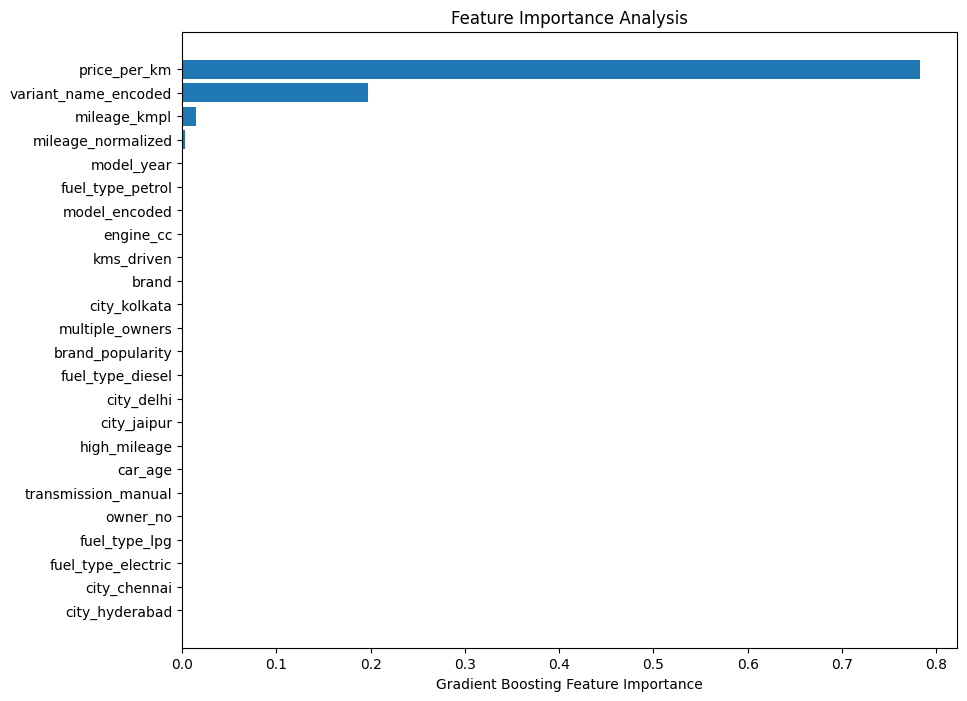

In [9]:
import matplotlib.pyplot as plt

# Feature importance for Gradient Boosting
if hasattr(models['Gradient Boosting'], 'feature_importances_'):
    feature_importance = models['Gradient Boosting'].feature_importances_
    sorted_idx = feature_importance.argsort()

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
    plt.xlabel("Gradient Boosting Feature Importance")
    plt.title("Feature Importance Analysis")
    plt.show()


Hyper Tuning

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',  # Use R2 score for evaluation
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the search
random_search.fit(X_train, y_train)

# Best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print(f"Best Parameters: {best_params}")

# Evaluate the tuned model on the validation set
y_val_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Tuned Gradient Boosting - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Save the best model
joblib.dump(best_model, 'PKL_Files/tuned_gradient_boosting.pkl')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
Tuned Gradient Boosting - MSE: 2798517339.0073, MAE: 22933.2611, R2: 0.9972


['PKL_Files/tuned_gradient_boosting.pkl']